In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import scipy.stats

def spm_hrf(TR,p=[6,16,1,1,6,0,32]):
    """ An implementation of spm_hrf.m from the SPM distribution

Arguments:

Required:
TR: repetition time at which to generate the HRF (in seconds)

Optional:
p: list with parameters of the two gamma functions:
                                                     defaults
                                                    (seconds)
   p[0] - delay of response (relative to onset)         6
   p[1] - delay of undershoot (relative to onset)      16
   p[2] - dispersion of response                        1
   p[3] - dispersion of undershoot                      1
   p[4] - ratio of response to undershoot               6
   p[5] - onset (seconds)                               0
   p[6] - length of kernel (seconds)                   32

"""

    p=[float(x) for x in p]

    fMRI_T = 16.0

    TR=float(TR)
    dt  = TR/fMRI_T
    u   = np.arange(p[6]/dt + 1) - p[5]/dt
    hrf=scipy.stats.gamma.pdf(u,p[0]/p[2],scale=1.0/(dt/p[2])) - scipy.stats.gamma.pdf(u,p[1]/p[3],scale=1.0/(dt/p[3]))/p[4]
    good_pts=np.array(range(int(p[6]/TR)))*fMRI_T
    hrf=hrf[list(good_pts.astype('int'))]
    # hrf = hrf([0:(p(7)/RT)]*fMRI_T + 1);
    hrf = hrf/np.sum(hrf);
    return hrf


In [2]:
mean = [0, 0]

cor = 0.4
cov = [[1, cor], [cor, 1]] 

x, y = np.random.multivariate_normal(mean, cov, 1000).T

df = pd.DataFrame({'x': x, 'y':  y})

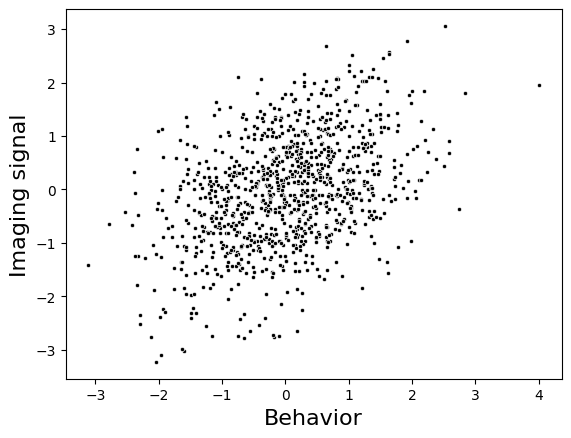

In [3]:
sns.scatterplot(x='x', y='y', data=df, color='k', marker='.')
plt.xlabel('Behavior', fontsize=16)
plt.ylabel('Imaging signal', fontsize=16)
plt.savefig('brain_behavior_scatterplot.png')

/tmp/ipykernel_62017/825400449.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


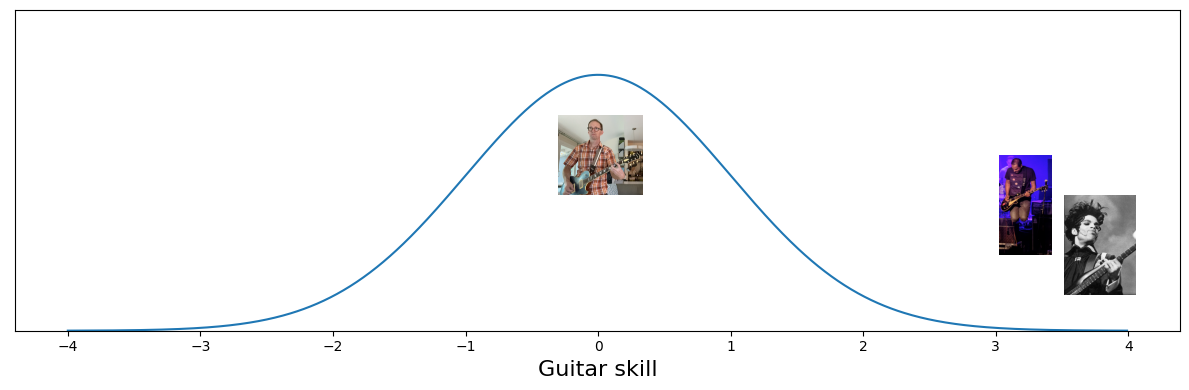

In [4]:
fig = plt.figure(figsize=(12,4))
x = np.arange(-4, 4, .01)
y = norm.pdf(x)
plt.plot(x,y)
plt.ylim([0, .5])
plt.xlabel('Guitar skill', fontsize=16)
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)

prince = plt.imread('Prince_cropped.jpg') # insert local path of the image.
charan = plt.imread('charan.jpg') # insert local path of the image.
rp = plt.imread('rp_guitar.png') # insert local path of the image.

def show_fig(fig, loc, img):
    newax = fig.add_axes(loc, anchor='NE', zorder=1)
    newax.imshow(img)
    newax.axis('off')

show_fig(fig, [0.7,0.25,0.25,0.25], prince)
show_fig(fig, [0.63,0.35,0.25,0.25], charan)
show_fig(fig, [0.34,0.5,0.2,0.2], rp)
plt.tight_layout()
plt.savefig('guitar_distribution.png')

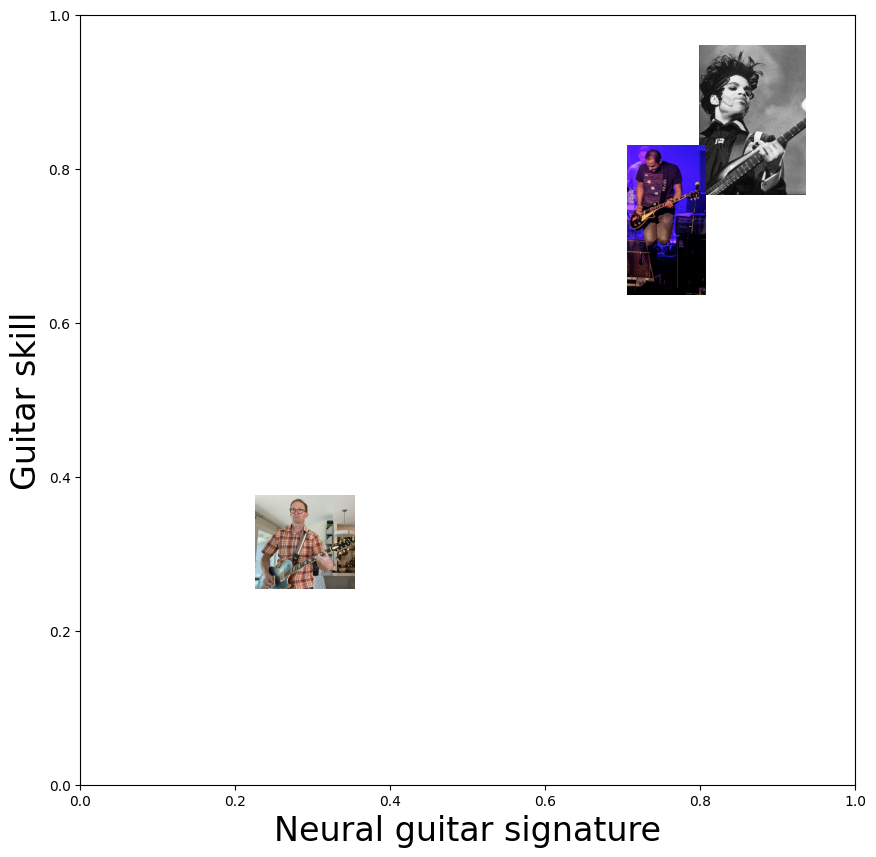

In [5]:
# neural guitar signature

fig = plt.figure(figsize=(10,10))
#x = np.arange(-4, 4, .01)
# y = norm.pdf(x)
# plt.plot(x,y)
plt.ylim([0, 1])
ax = plt.gca()

newax = fig.add_axes([0.7,0.7,0.15,0.15], anchor='NE', zorder=1)
newax.imshow(prince)
newax.axis('off')

newax2 = fig.add_axes([0.6,0.6,0.15,0.15], anchor='NE', zorder=1)
newax2.imshow(charan)
newax2.axis('off')


newax2 = fig.add_axes([0.3,0.3,0.1,0.1], anchor='NE', zorder=1)
newax2.imshow(rp)
newax2.axis('off')

ax.set_ylabel('Guitar skill', fontsize=24)
ax.set_xlabel('Neural guitar signature', fontsize=24)

plt.savefig('ngs.png')

In [6]:
# spike trains from poisson process

dt = 1

window_length = 1800
ntrials = 20

def create_trial(background_rate, stim_rate=None, stim_delta=None,
                 dt=1, window_len=1800):
    """
    create a trial with a background poisson process and a stimulus poisson process
    background_rate: rate of background poisson process
    stim_rate: rate of stimulus poisson process
    stim_delta: timeseries of binary indicators to add to background process
    dt: time bin size
    window_len: length of window in time bins

    """
    background_noise = np.random.uniform(size=window_len) < background_rate
    if stim_delta is None:
        stim_resp = np.zeros(window_len)
    else:
        assert stim_rate is not None, 'stim_rate must be specified with stim_delta'
        stim_resp = (np.random.uniform(size=window_len) < stim_rate) * stim_delta
    
    return background_noise + stim_resp

def create_trials(background_rate, ntrials, stim_rate=None, stim_delta=None):
    """
    create a set of trials with a background poisson process and a stimulus poisson process
    """
    trials = []
    for i in range(ntrials):
        trials.append(create_trial(background_rate, stim_rate, stim_delta))
    return np.array(trials)

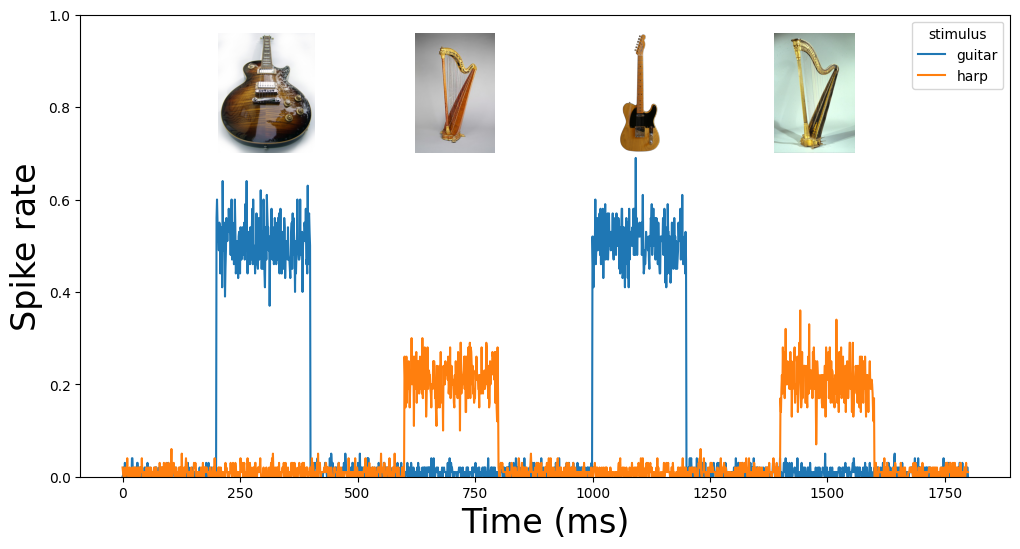

In [7]:

# stimulus intensity exmaple

guitar_delta = np.zeros(window_length)
harp_delta = np.zeros(window_length)

guitar_delta[200:400] = 1
guitar_delta[1000 :1200] = 1
harp_delta[600:800] = 1
harp_delta[1400:1600] = 1


fig = plt.figure(figsize=(12,6))

stim_rate = .3
ntrials = 100

guitar_trials = create_trials(.01, ntrials, .5, guitar_delta)
harp_trials = create_trials(.01, ntrials, .2, harp_delta)

rate_intensity_df = pd.DataFrame({'time': np.arange(window_length) * dt,
                        'guitar': np.mean(guitar_trials, axis=0),
                        'harp': np.mean(harp_trials, axis=0)}
                        ).melt(
                            id_vars='time',
                            var_name='stimulus',
                            value_name='spike_rate'
                        )

sns.lineplot(x='time', y='spike_rate', hue='stimulus',
             data=rate_intensity_df)
plt.ylim([0, 1])
plt.xlabel('Time (ms)', fontsize=24)
plt.ylabel('Spike rate', fontsize=24)

lespaul = plt.imread('lespaul.jpg') # insert local path of the image.
tele = plt.imread('telecaster.png') # insert local path of the image.
harp1 = plt.imread('harp1.jpg') # insert local path of the image.
harp2 = plt.imread('harp2.jpg') # insert local path of the image.

show_fig(fig, [0.12,0.65,0.2,0.2], lespaul)
show_fig(fig, [0.41,0.65,0.2,0.2], tele)
show_fig(fig, [0.27,0.65,0.2,0.2], harp1)
show_fig(fig, [0.57,0.65,0.2,0.2], harp2)

plt.savefig('rate_stim_intensity.png')




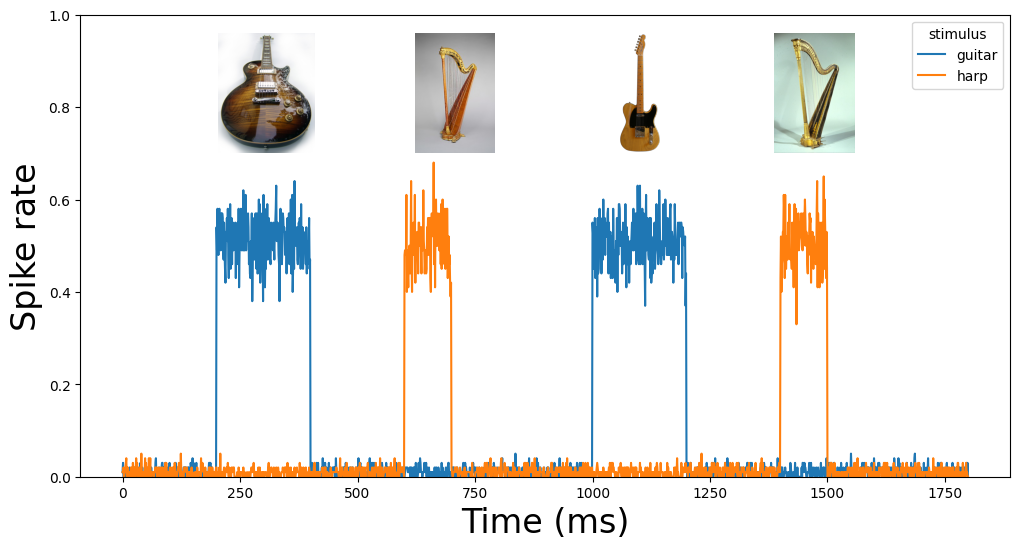

In [8]:

# stimulus duration exmaple

fig = plt.figure(figsize=(12,6))

guitar_delta = np.zeros(window_length)
harp_delta = np.zeros(window_length)

guitar_delta[200:400] = 1
guitar_delta[1000 :1200] = 1
harp_delta[600:700] = 1
harp_delta[1400:1500] = 1

stim_rate = .3
ntrials = 100

guitar_trials = create_trials(.01, ntrials, .5, guitar_delta)
harp_trials = create_trials(.01, ntrials, .5, harp_delta)

rate_duration_df = pd.DataFrame({'time': np.arange(window_length) * dt,
                        'guitar': np.mean(guitar_trials, axis=0),
                        'harp': np.mean(harp_trials, axis=0)}
                        ).melt(
                            id_vars='time',
                            var_name='stimulus',
                            value_name='spike_rate'
                        )

sns.lineplot(x='time', y='spike_rate', hue='stimulus',
             data=rate_duration_df)
plt.ylim([0, 1])
plt.xlabel('Time (ms)', fontsize=24)
plt.ylabel('Spike rate', fontsize=24)

lespaul = plt.imread('lespaul.jpg') # insert local path of the image.
tele = plt.imread('telecaster.png') # insert local path of the image.
harp1 = plt.imread('harp1.jpg') # insert local path of the image.
harp2 = plt.imread('harp2.jpg') # insert local path of the image.

show_fig(fig, [0.12,0.65,0.2,0.2], lespaul)
show_fig(fig, [0.41,0.65,0.2,0.2], tele)
show_fig(fig, [0.27,0.65,0.2,0.2], harp1)
show_fig(fig, [0.57,0.65,0.2,0.2], harp2)

plt.savefig('rate_stim_duration.png')

In [9]:

# fMRI response simulation for guitar vs harp

delta = .1

train_len = np.round(80/delta).astype(int)

guitar_delta_intensity = np.zeros(train_len)
harp_delta_intensity = np.zeros(train_len)

guitar_delta_duration = np.zeros(train_len)
harp_delta_duration = np.zeros(train_len)

guitar_intensity = 1
harp_intensity = .5
guitar_duration = np.round(1/delta).astype(int)
harp_duration = np.round(guitar_duration/2).astype(int)

response_scale = 10
guitar_times = [120, 440]

for t in guitar_times:
    # intensity-related response, same duration
    guitar_delta_intensity[t:t + guitar_duration] = guitar_intensity
    harp_delta_intensity[(t + 160):(t + guitar_duration + 160)] = harp_intensity

    # intensity-related response, same duration
    guitar_delta_duration[t:t + guitar_duration] = guitar_intensity
    harp_delta_duration[(t + 160):(t + harp_duration + 160)] = guitar_intensity

intensity_conv = np.convolve(guitar_delta_intensity + harp_delta_intensity, 
    spm_hrf(delta), mode='full')[:train_len] * response_scale

duration_conv = np.convolve(guitar_delta_duration + harp_delta_duration, 
    spm_hrf(delta), mode='full')[:train_len] * response_scale

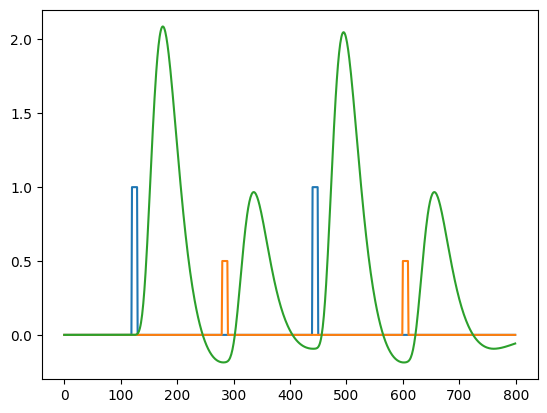

In [10]:
plt.plot(guitar_delta_intensity)
plt.plot(harp_delta_intensity)

plt.plot(intensity_conv)

plt.savefig('intensity_conv.png')

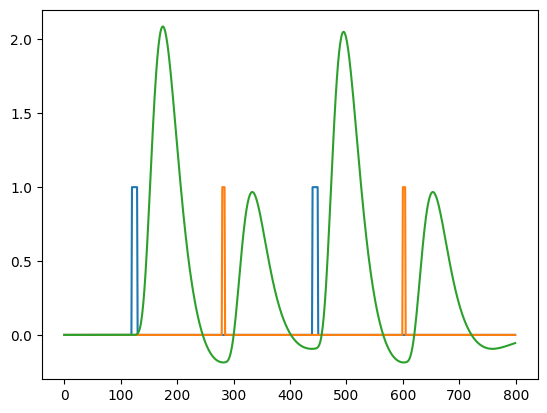

In [11]:

plt.plot(guitar_delta_duration)
plt.plot(harp_delta_duration)

plt.plot(duration_conv)
plt.savefig('duration_conv.png')

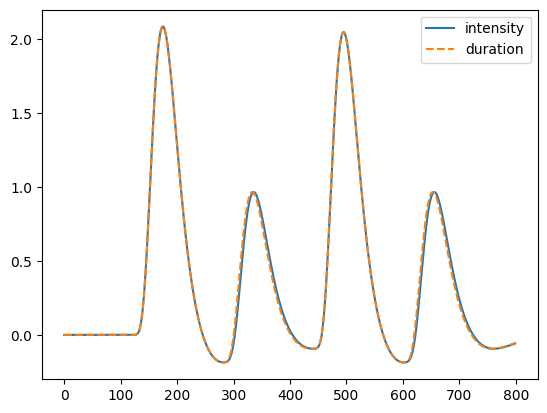

In [12]:

plt.plot(intensity_conv)
plt.plot(duration_conv, '--')
plt.legend(['intensity', 'duration'])

plt.savefig('intensity_duration_conv.png')

In [13]:

# fMRI response simulation for guitar vs harp

delta = .1

train_len = np.round(80/delta).astype(int)

guitar_delta_intensity = np.zeros(train_len)
harp_delta_intensity = np.zeros(train_len)

guitar_delta_duration = np.zeros(train_len)
harp_delta_duration = np.zeros(train_len)

guitar_intensity = 1
harp_intensity = 1
guitar_duration = np.round(1/delta).astype(int)
harp_duration = np.round(guitar_duration/2).astype(int)

response_scale = 10
guitar_times = [120, 440]

for t in guitar_times:
    # intensity-related response, same duration
    guitar_delta_intensity[t:t + guitar_duration] = guitar_intensity
    harp_delta_intensity[(t + 160):(t + guitar_duration + 160)] = harp_intensity

    # intensity-related response, same duration
    guitar_delta_duration[t:t + guitar_duration] = guitar_intensity
    harp_delta_duration[(t + 160):(t + harp_duration + 160)] = guitar_intensity

intensity_conv = np.convolve(guitar_delta_intensity + harp_delta_intensity, 
    spm_hrf(delta), mode='full')[:train_len] * response_scale

duration_conv = np.convolve(guitar_delta_duration + harp_delta_duration, 
    spm_hrf(delta), mode='full')[:train_len] * response_scale

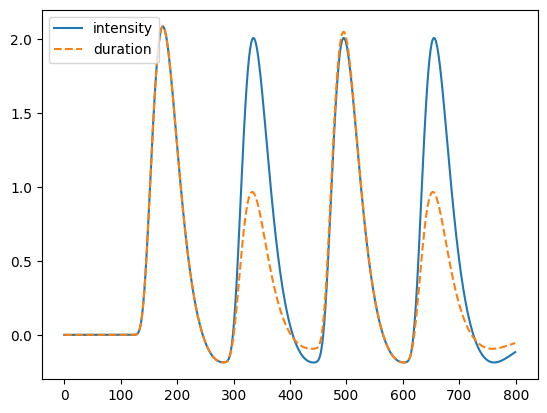

In [14]:
plt.plot(intensity_conv)
plt.plot(duration_conv, '--')
plt.legend(['intensity', 'duration'])

## BBA example


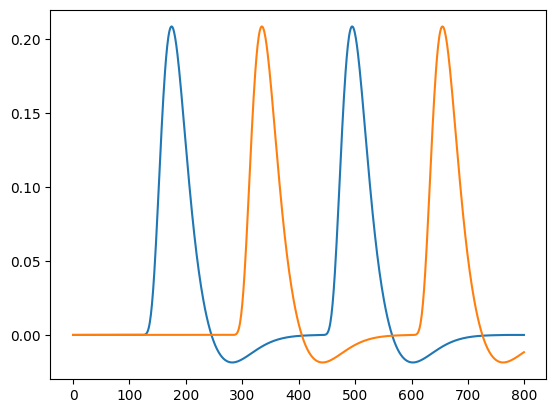

In [33]:
# function to create a design matrix with two trials
# default has equal intensity and duration for each condition

def mk_desmtx(guitar_intensity=1, harp_intensity=1,
              guitar_duration_secs=1, harp_duration_secs=1,
              delta=.1, trainlen_secs=80,  model_rt=None):
    # model_rt should contain the parameters used for generating the data
    # (g_i, h_i, g_d, h_d) if RT is being modeled
    if model_rt:
        # use mean duration for RT regressor length
        mean_duration =  np.round(1/delta).astype(int)
    
    train_len = np.round(trainlen_secs/delta).astype(int)

    desmtx = np.zeros((train_len, 3 + (model_rt is not None)))
    desmtx[:, -1] = 1


    guitar_duration = np.round(guitar_duration_secs/delta).astype(int)
    harp_duration = np.round(harp_duration_secs/delta).astype(int)

    guitar_times = [120, 440]

    for t in guitar_times:
        # intensity-related response, same duration
        desmtx[t:t + guitar_duration, 0] = guitar_intensity
        desmtx[(t + 160):(t + harp_duration + 160), 1] = harp_intensity
        if model_rt:
            desmtx[t:t + mean_duration, 2] = model_rt[2]
            desmtx[(t + 160):(t + mean_duration + 160), 2] = model_rt[3]
            

    desmtx_conv = np.zeros(desmtx.shape)
    desmtx_conv[:, -1] = 1

    for i in range(desmtx.shape[1] - 1):
        desmtx_conv[:,i] = np.convolve(desmtx[:,i], spm_hrf(delta), mode='full')[:train_len]

    return desmtx, desmtx_conv

_, model_desmtx = mk_desmtx()

plt.plot(model_desmtx[:, :-1])

In [34]:
# fit model and return betas
def fit_model(data, model_rt=None):
    y = data.reshape((-1, 1))
    # get the default design matrix with equal intensity and duration
    # if model_rt is set then use actual model_rt params to create RT regressor
    _, X = mk_desmtx(model_rt=model_rt)
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)



In [35]:
desmtx = {
    (1,1,1.2,0.8): mk_desmtx(guitar_duration_secs=1.2, harp_duration_secs=0.8),
    (1,1,1.4,0.6): mk_desmtx(guitar_duration_secs=1.4, harp_duration_secs=0.6),
}

data = {}
beta_hat = {}
bold_diff = []
rt_diff = []

idx = 0
for k, v in desmtx.items():
    data[k] = v[1].dot([1,1,1])
    beta_hat[k] = fit_model(data[k])
    bold_diff.append(beta_hat[k][0] - beta_hat[k][1])
    rt_diff.append(k[2] - k[3])
    print('params', k)
    print('bold_diff:', bold_diff[-1])
    print('beta_hat:', beta_hat[k].reshape(-1))
    print()


params (1, 1, 1.2, 0.8)
bold_diff: [0.39647164]
beta_hat: [1.19559121 0.79911956 1.00012082]

params (1, 1, 1.4, 0.6)
bold_diff: [0.79182559]
beta_hat: [1.38696512 0.59513954 1.00043215]



Text(0, 0.5, 'BOLD difference')

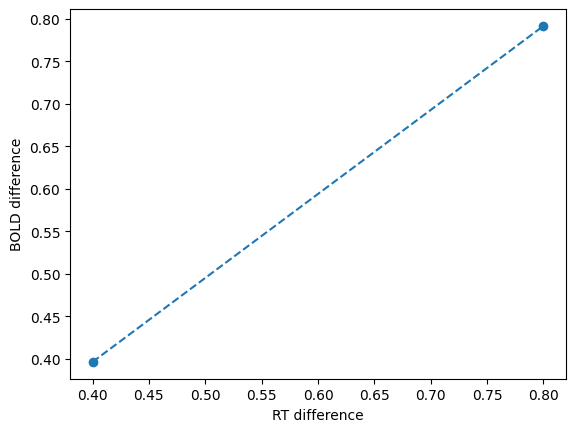

In [36]:
plt.scatter(rt_diff, bold_diff)
plt.plot(rt_diff, bold_diff, '--')
plt.xlabel('RT difference')
plt.ylabel('BOLD difference')

params (1, 1, 1.4, 0.6)
bold diff: [0.77969037]
beta_hat: [1.37816449 0.59847412 1.00064281]

params (2, 2, 1.4, 0.6)
bold diff: [1.57629845]
beta_hat: [2.76252977 1.18623132 1.00106917]



Text(0.5, 1.0, 'constant RT diff, intensity diff, no RT modeling')

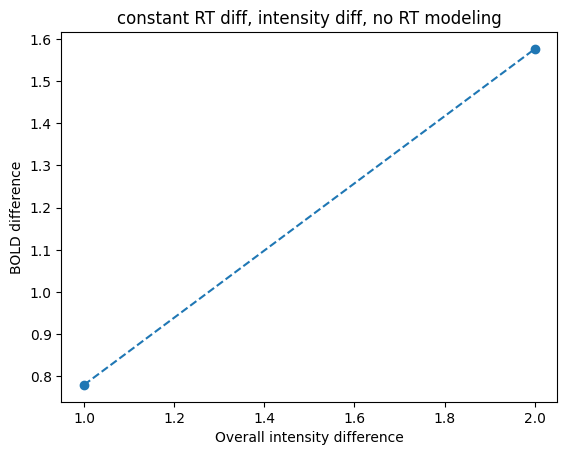

In [41]:
desmtx = {
    (1,1,1.4,0.6): mk_desmtx(guitar_duration_secs=1.4, harp_duration_secs=0.6),
    (2,2,1.4,0.6): mk_desmtx(guitar_duration_secs=1.4, harp_duration_secs=0.6,
                            guitar_intensity=2, harp_intensity=2),
    
}


data = {}
beta_hat = {}
bold_diff = []
rt_diff = []
dur = []
noise_sd = .01

idx = 0
for k, v in desmtx.items():
    # add a tiny bit of noise to prevent singular matrices
    data[k] = v[1].dot([1,1,1]) + np.random.normal(size=v[1].shape[0], scale=noise_sd)
    beta_hat[k] = fit_model(data[k])
    bold_diff.append(beta_hat[k][0] - beta_hat[k][1])
    rt_diff.append(k[2] - k[3])
    dur.append(k[0])
    print('params', k)
    print('bold diff:', bold_diff[-1])
    print('beta_hat:', beta_hat[k].reshape(-1))
    print()

plt.scatter(dur, bold_diff)
plt.plot(dur, bold_diff, '--')
plt.xlabel('Overall intensity difference')
plt.ylabel('BOLD difference')
plt.title('constant RT diff, intensity diff, no RT modeling')

params (1, 1, 1.4, 0.6)
bold diff: [0.45759924]
beta_hat: [-1.63282476 -2.090424    4.01464382  1.00064281]

params (2, 2, 1.4, 0.6)
bold diff: [1.47441469]
beta_hat: [-0.30875787 -1.78317255  4.3927107   1.00106917]



Text(0.5, 1.0, 'constant RT diff, intensity diff, with RT modeling')

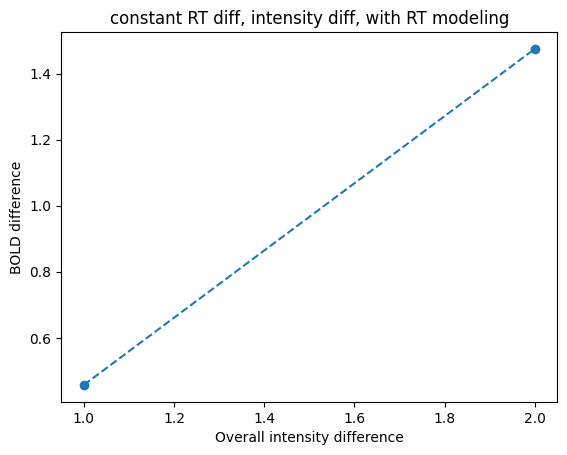

In [42]:

beta_hat = {}
bold_diff = []
rt_diff = []
dur = []

idx = 0
for k, v in desmtx.items():
    beta_hat[k] = fit_model(data[k], model_rt=k)
    bold_diff.append(beta_hat[k][0] - beta_hat[k][1])
    rt_diff.append(k[2] - k[3])
    dur.append(k[0])
    print('params', k)
    print('bold diff:', bold_diff[-1])
    print('beta_hat:', beta_hat[k].reshape(-1))
    print()

plt.scatter(dur, bold_diff)
plt.plot(dur, bold_diff, '--')
plt.xlabel('Overall intensity difference')
plt.ylabel('BOLD difference')
plt.title('constant RT diff, intensity diff, with RT modeling')

array([[ 1.        , -0.25251061,  0.90738899,         nan],
       [-0.25251061,  1.        ,  0.17754656,         nan],
       [ 0.90738899,  0.17754656,  1.        ,         nan],
       [        nan,         nan,         nan,         nan]])

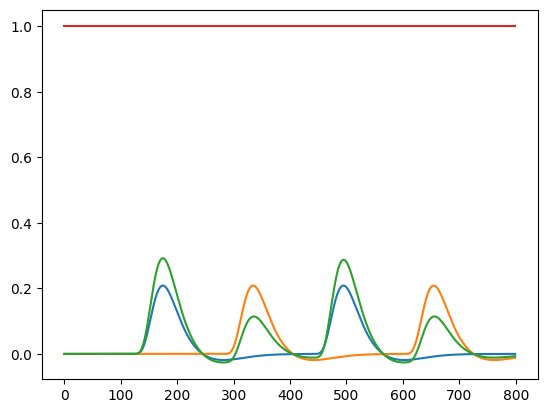

In [47]:
X = mk_desmtx(model_rt=k)[1]
plt.plot(X)
np.corrcoef(X.T)

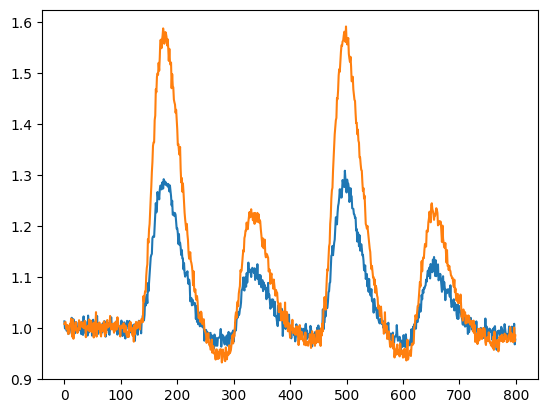

In [43]:
for k, v in desmtx.items():
    plt.plot(data[k])